In [181]:
import numpy as np
import json
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import math

## Load Wikipedia

In [3]:
WIKI_FILE_PATH = '../../../data/wiki_lookup.json'
wiki = json.load(open(WIKI_FILE_PATH))

## RAM Requirements

In [4]:
len(wiki.keys())

25808

We need to store a 25808x25808 matrix. Let's calculate how much RAM it takes to store this.

In [5]:
def ram_gb(r, c=None):
    if not c:
        c = r
    return (r*c*8) / 10**9

In [6]:
ram_gb(len(wiki.keys()))

5.328422912

In [7]:
ram_gb(7000000,100)

5.6

This matrix requires 5GB of RAM. This seems infeasible since Pagerank requires inversion, a very expensive matrix calculation. So we let's use a sparse matrix for now (since the number of entries in each row is far less than 25808).

## Matrix Format

Construct numeric index for each article

In [111]:
article_index = {}
index = 0
for article in wiki.keys():
    article_index[article] = index
    article_index[index] = article
    index += 1

In [120]:
counts = defaultdict(int)
for article in wiki.keys():
    counts[article.count('_')] += 1

<Container object of 15 artists>

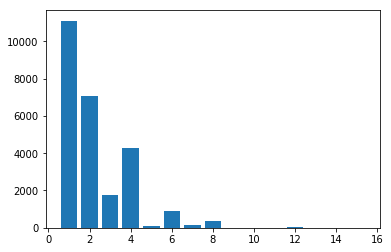

In [121]:
plt.bar(range(1,len(counts)+1), list(counts.values()), align='center')

In [122]:
.95*sum(counts.values())

24517.6

Construct page links

In [123]:
def clean_text(s):
    s = re.sub(r'[^\w\s]','',s)
    s = re.sub(r'[\n]',' ',s)
    return s

# Deprecated

In [149]:
%%time
links = defaultdict(set)
progress = 0

for article in wiki.keys():
    
    progress += 1
    if progress % 1000 == 0:
        print(progress/len(wiki.keys()))
        
    p_word = ''
    pp_word = ''
    ppp_word = ''
    
    for word in filter(lambda x: x[0].isupper(), clean_text(wiki[article]['text']).split()):       
        if word in wiki.keys():
            links[article].add(word)

        bigram = str('_'.join([p_word, word]))
        if p_word and bigram in wiki.keys():
            links[article].add(bigram)
            
        trigram = str('_'.join([pp_word, p_word, word]))
        if pp_word and trigram in wiki.keys():
            links[article].add(trigram)
            
        quadgram = str('_'.join([ppp_word, pp_word, p_word, word]))
        if ppp_word and quadgram in wiki.keys():
            links[article].add(quadgram)
        
        ppp_word = pp_word
        pp_word = p_word
        p_word = word

0.03874767513949163
0.07749535027898326
0.1162430254184749
0.15499070055796652
0.19373837569745817
0.2324860508369498
0.2712337259764414
0.30998140111593303
0.34872907625542465
0.38747675139491633
0.42622442653440795
0.4649721016738996
0.5037197768133912
0.5424674519528828
0.5812151270923744
0.6199628022318661
0.6587104773713577
0.6974581525108493
0.7362058276503409
0.7749535027898327
0.8137011779293243
0.8524488530688159
0.8911965282083075
0.9299442033477991
0.9686918784872908
CPU times: user 1min 17s, sys: 500 ms, total: 1min 18s
Wall time: 1min 18s


Note that some articles such as 'A' are linked to even though these are not articles. This is okay because *insert ReLU explanation.*

In [156]:
links_count = {}
for article, linked_articles in links.items():
    links_count[article] = len(linked_articles)

In [166]:
sorted(links_count.items(), key=lambda x: x[1])[::-1]

[('England', 448),
 ('United_Kingdom', 447),
 ('United_States', 444),
 ('France', 431),
 ('History_of_the_United_States', 400),
 ('Russia', 390),
 ('Germany', 372),
 ('New_York_City', 355),
 ('List_of_recurring_The_Simpsons_characters', 355),
 ('Italy', 341),
 ('Italian_Americans', 341),
 ('Bob_Dylan', 333),
 ('Chicago', 328),
 ('Socialism', 327),
 ('Europe', 319),
 ('John_F._Kennedy', 316),
 ('Czech_Republic', 312),
 ('Greece', 312),
 ('Paris', 309),
 ('Antisemitism', 307),
 ('London', 307),
 ('Orson_Welles', 306),
 ('Theodore_Roosevelt', 305),
 ('World_War_I', 304),
 ('1970s', 304),
 ('Ronald_Reagan', 302),
 ('Pope_John_Paul_II', 300),
 ('Liverpool', 298),
 ('Manhattan', 296),
 ('Dwight_D._Eisenhower', 294),
 ('Israel', 290),
 ('Genoa', 289),
 ('Spain', 287),
 ('Protestantism', 286),
 ('Red', 285),
 ('Slavery', 285),
 ('Sculpture', 283),
 ('Puerto_Rico', 282),
 ('University_of_Oxford', 282),
 ('Winston_Churchill', 278),
 ('Baltimore', 277),
 ('Cold_War', 277),
 ('Christianity', 275),

In [115]:
%%time
matrix = []
for article in wiki.keys():
    row = [0]*(len(wiki.keys()))
    for entry in links[article]:
        row[article_index[entry]] = 1
    matrix.append(row)

NameError: name 'links' is not defined

In [113]:
%time M = np.array(matrix)

NameError: name 'matrix' is not defined

In [180]:
M[article_index['Adolf_Hitler']][article_index['Nazi_Germany']]

1

## Sparse Matrix Build

In [124]:
from scipy.sparse import csc_matrix, csr_matrix, save_npz

In [125]:
%%time
row = []
col = []
data = []

progress = 0

for article in wiki.keys():
    
    progress += 1
    if progress % 1000 == 0:
        print(progress/len(wiki.keys()))
        
    p_word = ''
    pp_word = ''
    ppp_word = ''
    
    for word in filter(lambda x: x[0].isupper(), clean_text(wiki[article]['text']).split()):       
        if word in wiki.keys():
            col.append(article_index[article])
            row.append(article_index[word])
            data.append(1)

        bigram = str('_'.join([p_word, word]))
        if p_word and bigram in wiki.keys():
            col.append(article_index[article])
            row.append(article_index[bigram])
            data.append(1)
            
        trigram = str('_'.join([pp_word, p_word, word]))
        if pp_word and trigram in wiki.keys():
            col.append(article_index[article])
            row.append(article_index[trigram])
            data.append(1)
            
        quadgram = str('_'.join([ppp_word, pp_word, p_word, word]))
        if ppp_word and quadgram in wiki.keys():
            col.append(article_index[article])
            row.append(article_index[quadgram])
            data.append(1)
        
        ppp_word = pp_word
        pp_word = p_word
        p_word = word

0.03874767513949163
0.07749535027898326
0.1162430254184749
0.15499070055796652
0.19373837569745817
0.2324860508369498
0.2712337259764414
0.30998140111593303
0.34872907625542465
0.38747675139491633
0.42622442653440795
0.4649721016738996
0.5037197768133912
0.5424674519528828
0.5812151270923744
0.6199628022318661
0.6587104773713577
0.6974581525108493
0.7362058276503409
0.7749535027898327
0.8137011779293243
0.8524488530688159
0.8911965282083075
0.9299442033477991
0.9686918784872908
CPU times: user 1min 11s, sys: 281 ms, total: 1min 11s
Wall time: 1min 11s


In [126]:
sparse = csc_matrix((data, (row, col)), shape=(len(wiki.keys()),len(wiki.keys())))

In [16]:
save_npz('sparse_links_n.npz', sparse)

In [127]:
sparse_t = np.transpose(sparse)
for i in range(len(wiki.keys())):
    if sparse_t[i].nnz == 0:
        sparse[i,i] = 1

/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [128]:
scaled_sparse = sparse / sparse.sum(axis=0)
scaled_sparse

matrix([[0.03571429, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.38235294, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

We can rewrite the PageRank matrix multiplication procedure into an iterative algorithm to make use of our sparse matrices and save memory.

In [175]:
def pagerank(G, beta=0.85, epsilon=10**-4):
    n,_ = G.shape
    deg_out_beta = G.sum(axis=0).T/beta
    ranks = np.ones((n,1)) / n
    time = 0
    converged = False
    while not converged:        
        time +=1
        with np.errstate(divide='ignore'): 
            new_ranks = G.dot((ranks/deg_out_beta))
        new_ranks += (1-new_ranks.sum())/n
        if np.linalg.norm(ranks-new_ranks,ord=1) <= epsilon:
            converged = True
        ranks = new_ranks
    return(np.squeeze(np.asarray(ranks)), time)

In [176]:
%time rank, iters = pagerank(scaled_sparse)
print("Iterations: {0}".format(iters))
print("Element with the highest PageRank: {0}".format(np.argmax(rank)))

CPU times: user 19.8 s, sys: 220 ms, total: 20.1 s
Wall time: 5.5 s
Iterations: 20
Element with the highest PageRank: 1866


In [173]:
top_ten = np.argsort(rank)[:-10:-1]
bottom_ten = np.argsort(rank)[:10]

In [172]:
[article_index[ind] for ind in top_ten]

['The',
 'A',
 'Latin',
 'Middle_English',
 'Old_English',
 'Modern_English',
 'England',
 'Europe',
 'King']

In [174]:
[article_index[ind] for ind in bottom_ten]

['List_of_Crusader_castles',
 'Safety_bicycle',
 'Louise_(opera)',
 'Sede_vacante',
 'Elastic_scattering',
 'The_Power_and_the_Glory',
 'Star_Wars:_Knights_of_the_Old_Republic',
 'A_Report_to_an_Academy',
 'The_Outcasts_of_Poker_Flat',
 'Dombey_and_Son']

In [185]:
np.histogram(rank)

(array([25802,     5,     0,     0,     0,     0,     0,     0,     0,
            1]),
 array([5.81215127e-06, 1.43003827e-02, 2.85949533e-02, 4.28895238e-02,
        5.71840944e-02, 7.14786649e-02, 8.57732355e-02, 1.00067806e-01,
        1.14362377e-01, 1.28656947e-01, 1.42951518e-01]))

In [195]:
d = defaultdict(int)
for x in rank:
    d[x] += 1
d

defaultdict(int,
            {6.212797807948481e-06: 1,
             5.812151270923831e-06: 10336,
             8.610594480651853e-06: 1,
             6.448922132591209e-06: 1,
             4.70765858502001e-05: 1,
             6.61285919579905e-06: 1,
             9.547409693878918e-06: 1,
             7.078902188945715e-06: 3,
             6.146952022010168e-06: 1,
             6.136651003254189e-06: 1,
             1.080700129076789e-05: 1,
             6.605636076606109e-06: 1,
             6.129750202790813e-06: 1,
             9.400109225740643e-06: 1,
             6.394071825332868e-06: 1,
             6.171695856727887e-06: 1,
             6.153682442921468e-06: 1,
             6.1582687946644915e-06: 1,
             6.42110822066429e-06: 1,
             3.702448783493524e-05: 1,
             6.519596891012405e-06: 1,
             6.3107375018816825e-06: 1,
             1.6398639273213322e-05: 1,
             5.926643242656977e-06: 5,
             2.363795165303809e-05: 1,
    

In [201]:
d_norm = d
d_norm[5.812151270923831e-06] = 0

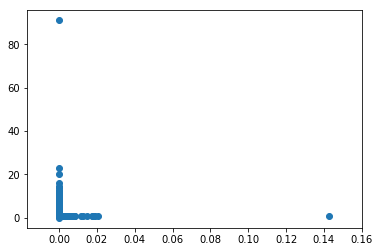

In [202]:
plt.scatter(d_norm.keys(), d_norm.values())

This plot shows that the graph has very few nodes (articles) where a player is more likely to end up at it then any other node.